# Package

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# importation des données

In [2]:
df_stationary_train = pd.read_csv("df_stationary_train.csv", index_col="date")
df_stationary_train.index = pd.to_datetime(df_stationary_train.index)
df_stationary_test = pd.read_csv("df_stationary_test.csv", index_col="date")
df_stationary_test.index = pd.to_datetime(df_stationary_test.index)

In [3]:
df_stationary_train

,UNRATE,TB3MS,RPI,INDPRO,DPCERA3M086SBEA,S&P 500,BUSLOANS,CPIAUCSL,OILPRICEx,M2SL,USREC
date,,,,,,,,,,,
1960-01-31,-0.8,0.30,0.020977,0.091980,0.001204,0.017909,0.011578,-0.006156,0.000000,0.001323,0
1960-02-29,-1.1,-0.19,0.014565,0.076964,0.006009,-0.025663,0.011905,-0.003767,0.000000,0.002007,0
1960-03-31,-0.2,-1.18,0.006250,0.007961,0.021240,-0.070857,-0.008356,-0.005455,0.000000,0.001324,0
1960-04-30,0.0,-1.12,0.006489,-0.025915,0.033752,-0.040442,-0.009098,0.005090,0.000000,0.000634,1
1960-05-31,0.0,-0.67,0.007747,-0.018121,0.009040,-0.010090,-0.000359,0.003383,0.000000,0.003977,1
...,...,...,...,...,...,...,...,...,...,...,...
1989-07-31,-0.2,-0.77,0.001769,-0.015259,0.003755,0.093414,-0.002184,-0.004246,-0.225652,0.010549,0
1989-08-31,-0.4,-0.53,0.008277,-0.000039,0.014490,0.099097,0.005449,-0.010676,-0.195045,0.014176,0
1989-09-30,-0.1,-0.40,0.008246,-0.003350,0.010644,0.070372,0.007701,-0.009804,-0.049151,0.011753,0


In [4]:
df_stationary_train_unrate = df_stationary_train["UNRATE"]
df_stationary_test_unrate = df_stationary_test["UNRATE"]

In [33]:
df_stationary_train_unrate.head()

date
1960-01-31   -0.8
1960-02-29   -1.1
1960-03-31   -0.2
1960-04-30    0.0
1960-05-31    0.0
Name: UNRATE, dtype: float64

In [37]:
df_stationary_train_unrate

date
1960-01-31   -0.8
1960-02-29   -1.1
1960-03-31   -0.2
1960-04-30    0.0
1960-05-31    0.0
             ... 
1989-07-31   -0.2
1989-08-31   -0.4
1989-09-30   -0.1
1989-10-31   -0.1
1989-11-30    0.1
Name: UNRATE, Length: 359, dtype: float64

# AR(1)

## Autocorrélation

<Figure size 640x480 with 0 Axes>

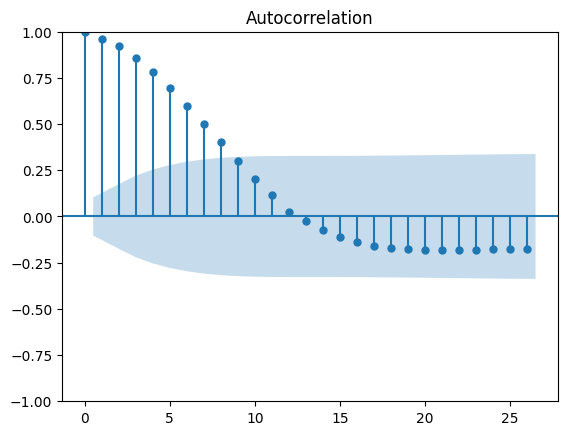

In [6]:
plt.figure()
plot_acf(df_stationary_train_unrate)
plt.show()

<Figure size 640x480 with 0 Axes>

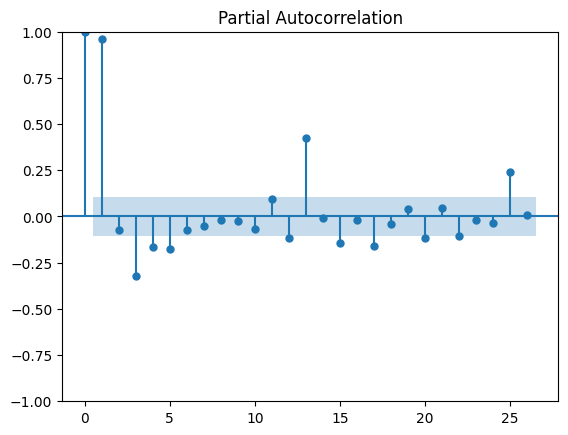

In [7]:
plt.figure()
plot_pacf(df_stationary_train_unrate)
plt.show()

Le graphique ACF montre une décroissance progressive et régulière vers zéro → typique d’un processus autorégressif (AR).

Le graphique PACF présente une coupure nette après le lag 1, c’est-à-dire que seule la première autocorrélation partielle est significative.

La série suit très probablement un modèle AR(1) (autorégressif d’ordre 1).

# Implémentation de AR(1)

In [18]:
# ==========================================
# AR(1) — Prévisions OOS h=12 (expanding) + Évaluation 1983–1989
# ==========================================
import numpy as np
import pandas as pd
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# -------- 0) Série cible (ΔUNRATE déjà différenciée) --------
y = df_stationary_train_unrate.squeeze().sort_index().astype(float).dropna()

# index mensuel début de mois
y.index = pd.to_datetime(y.index).to_period("M").to_timestamp(how="start")
y = y.asfreq("MS")

# garde-fou : fréquence régulière
assert y.index.freq == "MS", "Index non régulier (MS). Vérifie qu'il n'y a pas de mois manquant."

print(f"y: {y.index.min().date()} → {y.index.max().date()}  (n={len(y)}) | freq={y.index.freqstr}")

# -------- 1) Paramètres --------
h = 12
min_train_n = 36          # ≥ 3 ans
eval_start = pd.Timestamp("1983-01-01")
eval_end   = pd.Timestamp("1989-12-31")

# -------- 2) Boucle expanding + prévision à h --------
rows = []
last_model = None
last_fit_end = None

last_t_end = y.index.max() - relativedelta(months=h)

for t_end in y.index:
    if t_end > last_t_end:
        break

    y_tr = y.loc[:t_end]
    if len(y_tr) < min_train_n:
        continue

    # AR(1) avec constante (trend='c'). Mettre trend='n' si vous ne voulez pas de constante.
    ar1 = AutoReg(y_tr, lags=1, old_names=False, trend='c').fit()
    last_model = ar1
    last_fit_end = t_end

    # prévision récursive jusqu'à h, on prend la valeur à l'horizon
    fc = ar1.predict(start=len(y_tr), end=len(y_tr) + h - 1)
    yhat_h = float(fc.iloc[-1])

    t_fore = t_end + relativedelta(months=h)
    if t_fore in y.index:
        rows.append((t_fore, yhat_h, float(y.loc[t_fore])))

# -------- 3) Agrégation des prévisions --------
if rows:
    df_oos_ar1 = (
        pd.DataFrame(rows, columns=["date", "y_hat", "y_true"])
          .set_index("date")
          .sort_index()
    )
else:
    df_oos_ar1 = pd.DataFrame(columns=["y_hat", "y_true"])
    df_oos_ar1.index = pd.to_datetime(pd.Index([]))
    print("⚠️ Pas de prévisions générées (vérifie la longueur de y / min_train_n).")

print(f"n prévisions générées: {len(df_oos_ar1)} | fenêtre d’éval: {eval_start.date()}–{eval_end.date()}")

# -------- 4) Évaluation 1983–1989 --------
df_eval = df_oos_ar1.loc[eval_start:eval_end].copy()

if len(df_eval) > 0:
    mae  = mean_absolute_error(df_eval["y_true"], df_eval["y_hat"])
    rmse = float(np.sqrt(mean_squared_error(df_eval["y_true"], df_eval["y_hat"])))
    r2   = r2_score(df_eval["y_true"], df_eval["y_hat"]) if len(df_eval) > 1 else np.nan

    print(f"\n✅ AR(1) OOS (h=12) — Évaluation 1983–1989 — n={len(df_eval)}")
    print(f"MAE = {mae:.3f} | RMSE = {rmse:.3f} | R² = {r2:.3f}")

    # ---- Détails annuels (sans FutureWarning) ----
    err = df_eval["y_true"] - df_eval["y_hat"]
    tmp = df_eval.assign(
        year=df_eval.index.year,
        AE=np.abs(err),
        SE=err**2,
    )
    yearly = tmp.groupby("year").agg(
        n=("y_true", "size"),
        MAE=("AE", "mean"),
        RMSE=("SE", lambda s: float(np.sqrt(s.mean()))),
    )
    print("\n--- MAE/RMSE par année (1983–1989) ---")
    print(yearly.to_string())
else:
    print("⚠️ Aucune observation dans la fenêtre 1983–1989.")

# df_oos_ar1 contient toutes les prévisions OOS ; df_eval la tranche 1983–1989.

y: 1960-01-01 → 1989-11-01  (n=359) | freq=MS
n prévisions générées: 312 | fenêtre d’éval: 1983-01-01–1989-12-31

✅ AR(1) OOS (h=12) — Évaluation 1983–1989 — n=83
MAE = 0.978 | RMSE = 1.461 | R² = -1.724

--- MAE/RMSE par année (1983–1989) ---
       n       MAE      RMSE
year                        
1983  12  1.895235  2.356209
1984  12  2.257664  2.595748
1985  12  1.129074  1.240798
1986  12  0.175455  0.232867
1987  12  0.787346  0.818619
1988  12  0.301074  0.381930
1989  11  0.235163  0.265309


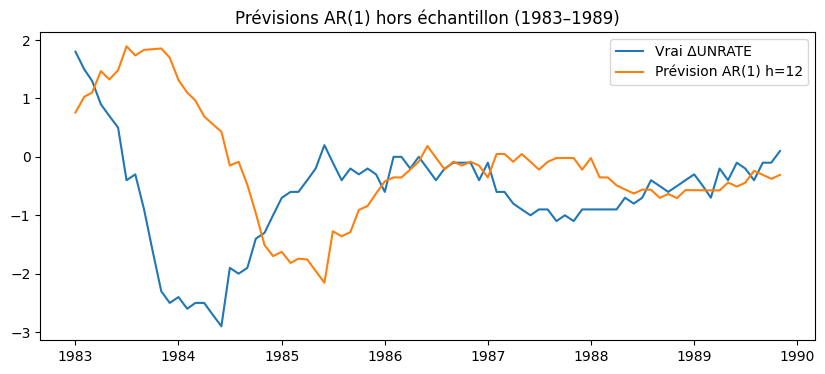

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(df_eval.index, df_eval["y_true"], label="Vrai ΔUNRATE")
plt.plot(df_eval.index, df_eval["y_hat"], label="Prévision AR(1) h=12")
plt.legend()
plt.title("Prévisions AR(1) hors échantillon (1983–1989)")
plt.show()

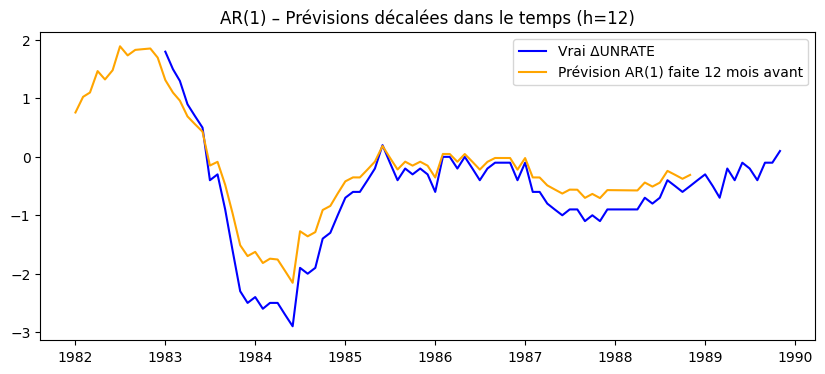

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(10,4))
plt.plot(df_eval.index, df_eval["y_true"], label="Vrai ΔUNRATE", color="blue")
plt.plot(df_eval.index - pd.DateOffset(months=12),
         df_eval["y_hat"], label="Prévision AR(1) faite 12 mois avant", color="orange")

plt.title("AR(1) – Prévisions décalées dans le temps (h=12)")
plt.legend()
plt.show()

In [22]:
# Série d'erreurs (alignée : vraie évaluation)
err = df_eval["y_true"] - df_eval["y_hat"]

diag = pd.DataFrame({
    "y_true": df_eval["y_true"],
    "y_hat":  df_eval["y_hat"],
    "abs_err": err.abs()
})
print("Top 10 des plus grosses erreurs (alignées) :")
print(diag.sort_values("abs_err", ascending=False).head(10))

Top 10 des plus grosses erreurs (alignées) :
            y_true     y_hat   abs_err
date                                  
1983-12-01    -2.5  1.698242  4.198242
1983-11-01    -2.3  1.854377  4.154377
1984-01-01    -2.4  1.313720  3.713720
1984-02-01    -2.6  1.099760  3.699760
1984-03-01    -2.5  0.962314  3.462314
1983-10-01    -1.6  1.842806  3.442806
1984-06-01    -2.9  0.430400  3.330400
1984-05-01    -2.7  0.560589  3.260589
1984-04-01    -2.5  0.691926  3.191926
1983-09-01    -0.9  1.830815  2.730815


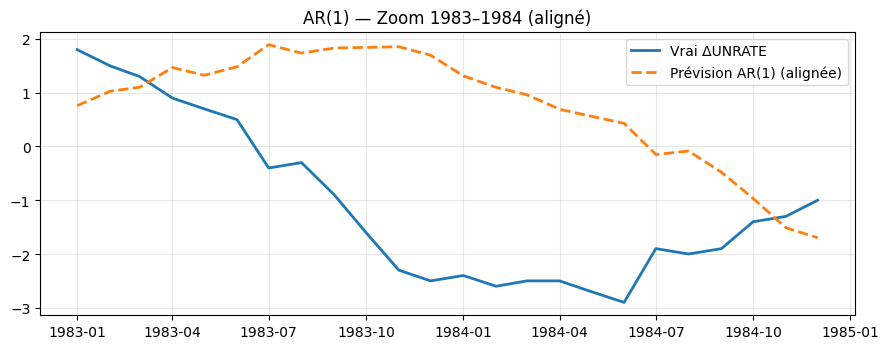

In [23]:
import matplotlib.pyplot as plt

z = df_eval.loc["1983":"1984", ["y_true","y_hat"]]
plt.figure(figsize=(9,3.6))
plt.plot(z.index, z["y_true"], label="Vrai ΔUNRATE", lw=2)
plt.plot(z.index, z["y_hat"],  label="Prévision AR(1) (alignée)", lw=2, ls="--")
plt.title("AR(1) — Zoom 1983–1984 (aligné)")
plt.legend(); plt.grid(alpha=.3); plt.tight_layout(); plt.show()

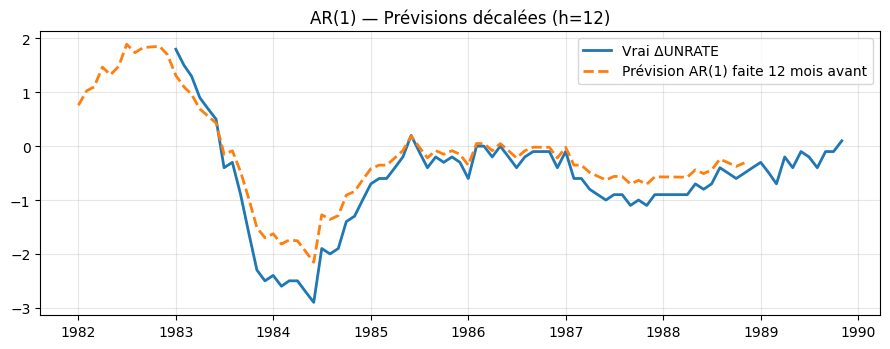

In [24]:
plt.figure(figsize=(9,3.6))
plt.plot(df_eval.index, df_eval["y_true"], label="Vrai ΔUNRATE", lw=2)
plt.plot(df_eval.index - pd.DateOffset(months=12),
         df_eval["y_hat"], label="Prévision AR(1) faite 12 mois avant", lw=2, ls="--")
plt.title("AR(1) — Prévisions décalées (h=12)")
plt.legend(); plt.grid(alpha=.3); plt.tight_layout(); plt.show()

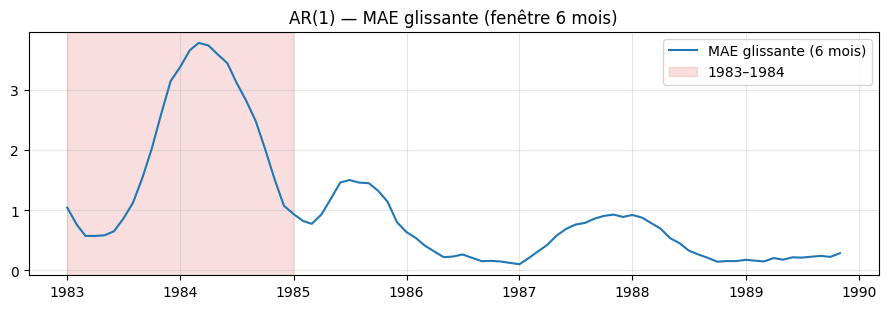

In [25]:
roll_mae = err.abs().rolling(6, min_periods=1).mean()
plt.figure(figsize=(9,3.2))
plt.plot(roll_mae.index, roll_mae, label="MAE glissante (6 mois)")
plt.axvspan(pd.Timestamp("1983-01-01"), pd.Timestamp("1984-12-31"),
            color="tab:red", alpha=0.15, label="1983–1984")
plt.title("AR(1) — MAE glissante (fenêtre 6 mois)")
plt.legend(); plt.grid(alpha=.3); plt.tight_layout(); plt.show()

In [26]:
by_year = (
    df_eval.assign(year=df_eval.index.year)
           .groupby("year")
           .apply(lambda g: pd.Series({
               "n": len(g),
               "MAE": mean_absolute_error(g["y_true"], g["y_hat"]),
               "RMSE": np.sqrt(mean_squared_error(g["y_true"], g["y_hat"]))
           }))
)
print(by_year.loc[1983:1984])

         n       MAE      RMSE
year                          
1983  12.0  1.895235  2.356209
1984  12.0  2.257664  2.595748


C:\Users\Mita\AppData\Local\Temp\ipykernel_2512\66949015.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


In [27]:
true_smooth = df_eval["y_true"].rolling(6, min_periods=1).mean()
mae_raw    = mean_absolute_error(df_eval["y_true"], df_eval["y_hat"])
mae_smooth = mean_absolute_error(true_smooth, df_eval["y_hat"])
print(f"MAE vs y_true        : {mae_raw:.3f}")
print(f"MAE vs y_true (lissé): {mae_smooth:.3f}")

MAE vs y_true        : 0.978
MAE vs y_true (lissé): 0.795


In [28]:
# ==========================================
# AR(1) OOS h=12 — bundle compatible linéaire
# ==========================================
import numpy as np
import pandas as pd
import joblib
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --------- 0) Utilitaires ---------
def normalize_month_start(series_like):
    """
    Convertit en Timestamp début de mois (freq MS).
    Accepte Series/array/list de dates.
    """
    s = pd.to_datetime(series_like, errors="coerce")
    # important : utiliser l'accessor .dt pour éviter l'erreur RangeIndex
    return s.dt.to_period("M").dt.to_timestamp(how="start")

# --------- 1) Série cible (ΔUNRATE) ---------
# Hypothèse : df_stationary_train_unrate existe (Series/DataFrame une colonne)
y = df_stationary_train_unrate.squeeze().sort_index().astype(float).dropna()

# Index mensuel (début de mois)
y.index = pd.to_datetime(y.index)
y.index = y.index.to_period("M").to_timestamp(how="start")
y = y.asfreq("MS")

# --------- 2) Paramètres ---------
h = 12
min_train_n = 36            # au moins 3 ans
eval_start = pd.Timestamp("1983-01-01")
eval_end   = pd.Timestamp("1989-12-31")

# --------- 3) Prévisions OOS (expanding, horizon h=12) ---------
rows = []
last_model = None
last_fit_end = None

last_t_end = y.index.max() - relativedelta(months=h)

for t_end in y.index:
    if t_end > last_t_end:
        break

    y_tr = y.loc[:t_end].dropna()
    if len(y_tr) < min_train_n:
        continue

    ar1 = AutoReg(y_tr, lags=1, old_names=False).fit()
    last_model = ar1
    last_fit_end = t_end

    # forecast récursif jusqu'à h
    fc = ar1.predict(start=len(y_tr), end=len(y_tr) + h - 1)
    yhat_h = float(fc.iloc[-1])

    t_fore = t_end + relativedelta(months=h)
    if t_fore in y.index:
        rows.append((t_fore, yhat_h, float(y.loc[t_fore])))

# Agrégation
if rows:
    df_oos_ar1 = (
        pd.DataFrame(rows, columns=["date", "y_hat", "y_true"])
        .set_index("date")
        .sort_index()
    )
else:
    df_oos_ar1 = pd.DataFrame(columns=["y_hat", "y_true"])
    df_oos_ar1.index = pd.to_datetime(pd.Index([]))
    print("⚠️ Pas de prévisions générées (vérifie la longueur de y).")

# --------- 4) Évaluation sur 1983–1989 ---------
df_eval = df_oos_ar1.loc[eval_start:eval_end].copy()

metrics = {}
if len(df_eval) > 0:
    mae  = mean_absolute_error(df_eval["y_true"], df_eval["y_hat"])
    rmse = np.sqrt(mean_squared_error(df_eval["y_true"], df_eval["y_hat"]))
    r2   = r2_score(df_eval["y_true"], df_eval["y_hat"]) if len(df_eval) > 1 else np.nan
    metrics = {"MAE": float(mae), "RMSE": float(rmse), "R2": (None if np.isnan(r2) else float(r2))}
    print(f"\n✅ AR(1) OOS (h=12) — Évaluation 1983–1989 — n={len(df_eval)}")
    print(f"MAE = {mae:.3f} | RMSE = {rmse:.3f} | R² = {r2:.3f}")
else:
    print("⚠️ Aucune observation dans la fenêtre 1983–1989.")

# --------- 5) oos_predictions NORMALISÉ (format compatible) ---------
oos = (
    df_oos_ar1.loc[eval_start:eval_end, ["y_true", "y_hat"]]
    .rename(columns={"y_hat": "y_pred"})
    .reset_index()                         # colonnes: date, y_true, y_pred
)
oos["date"] = normalize_month_start(oos["date"])

# --------- 6) Construire le bundle et sauvegarder ---------
ar_bundle = {
    "oos_predictions": oos,   # pandas DataFrame: date, y_true, y_pred
    "params": {
        "model": "AR(1)",
        "lag": 1,
        "horizon": h,
        "min_train_n": min_train_n,
        "eval_start": str(eval_start.date()),
        "eval_end": str(eval_end.date()),
        "hyper_type": "expanding_oos"
    },
    "features": 1,
    "metrics": metrics,       # <- pratique pour lecture rapide sans recalcul
    "meta": {
        "source": "AutoReg(statsmodels)",
        "index_freq": "MS",
        "last_fit_end": str(last_fit_end.date()) if last_fit_end is not None else None
    }
}

# Sauvegardes
joblib.dump(ar_bundle, "AR1_h12_oos_bundle.pkl")
joblib.dump(last_model, "AR1_last_trained_model.pkl")
print("\n💾 Sauvegardes faites : 'AR1_h12_oos_bundle.pkl' et 'AR1_last_trained_model.pkl'.")

# --------- 7) (Option) Préparer df_ar pour pipeline de plots ---------
df_ar = ar_bundle["oos_predictions"].rename(columns={"y_true": "true", "y_pred": "pred"}).copy()
df_ar["method"] = "AR1"  # pour fusion avec df_lin


✅ AR(1) OOS (h=12) — Évaluation 1983–1989 — n=83
MAE = 0.978 | RMSE = 1.461 | R² = -1.724

💾 Sauvegardes faites : 'AR1_h12_oos_bundle.pkl' et 'AR1_last_trained_model.pkl'.


In [29]:
# --- 6bis) Écrire le méta CSV compatible avec try_read_meta ---
import sys, platform, json, statsmodels

ar_meta = {
    # --- infos expérience / données ---
    "experiment":          "UNRATE_delta_AR1_h12",
    "target_name":         "ΔUNRATE",
    "is_stationary_input": True,
    "freq":                "MS",
    "y_start":             str(y.index.min().date()) if len(y) else None,
    "y_end":               str(y.index.max().date()) if len(y) else None,
    "y_length":            int(len(y)),

    # --- specs modèle / protocole ---
    "model":               "AR",
    "order_p":             1,
    "const_included":      getattr(last_model, "trend", "c") if last_model is not None else None,
    "trained_until":       str(last_fit_end.date()) if last_fit_end is not None else None,
    "horizon":             int(h),
    "windowing":           "expanding",
    "min_train_n":         int(min_train_n),
    "eval_start":          str(eval_start.date()),
    "eval_end":            str(eval_end.date()),
    "n_eval":              int(len(df_eval)),

    # --- critères & perfs ---
    "aic":                 float(getattr(last_model, "aic", np.nan)) if last_model is not None else np.nan,
    "bic":                 float(getattr(last_model, "bic", np.nan)) if last_model is not None else np.nan,
    "mae_83_89":           (metrics.get("MAE")  if metrics else None),
    "rmse_83_89":          (metrics.get("RMSE") if metrics else None),
    "r2_83_89":            (metrics.get("R2")   if metrics else None),

    # --- coefficients du dernier fit (JSON, 1 cellule) ---
    "last_params_json":    (json.dumps({k: float(v) for k, v in last_model.params.items()})
                            if last_model is not None else None),

    # --- environnement (traçabilité) ---
    "created_at_utc":      pd.Timestamp.utcnow().isoformat(),
    "python_version":      sys.version.split()[0],
    "pandas_version":      pd.__version__,
    "statsmodels_version": statsmodels.__version__,
    "numpy_version":       np.__version__,
    "platform":            platform.platform(),
}

pd.Series(ar_meta, name="value").to_csv("AR1_last_trained_model_meta.csv")
print("📝 Méta AR(1) écrit : 'AR1_last_trained_model_meta.csv'")

📝 Méta AR(1) écrit : 'AR1_last_trained_model_meta.csv'


# AR(p)

In [39]:
# --- paramètres de calendrier pour la CV ---
cv_update_every_months = 36        # tous les 36 mois
cv_anchor = pd.Timestamp("1983-01-01")  # point de départ EXACT de la CV

def months_since(anchor, t):
    return (t.year - anchor.year) * 12 + (t.month - anchor.month)

rows = []
last_model = None
last_fit_end = None
current_p = None   # p utilisé pour le fit courant (sera choisi à 1983-01)

last_t_end = y.index.max() - relativedelta(months=h)

for t_end in y.index:
    if t_end > last_t_end:
        break

    y_tr = y.loc[:t_end]
    if len(y_tr) < min_train_n:
        continue

    # ---------- règle de déclenchement de la CV ----------
    # 1) on ne CV QUE si t_end >= 1983-01
    # 2) on ne CV QUE sur une grille de 36 mois : 1983-01, 1986-01, 1989-01, ...
    # 3) et si t_end <= eval_end (optionnel ; tu peux l’enlever si tu veux continuer après 1989)
    if t_end >= cv_anchor and t_end <= eval_end:
        m = months_since(cv_anchor, t_end)
        need_cv = (m % cv_update_every_months == 0)
    else:
        need_cv = False

    # Au tout début (avant 1983), on n’a pas de p sélectionné.
    # On peut soit ne rien faire, soit utiliser un p par défaut.
    if current_p is None and not need_cv:
        # pas de CV avant 1983 : on met un p temporaire (il ne sera pas compté dans l'éval 83-89)
        current_p = 1

    if need_cv:
        # Sélection de p par pseudo-CV rolling MAE (comme défini avant)
        current_p = select_p_by_cv(y_tr, p_grid, h, min_train_n)
        # log propre
        print(f"[CV] {t_end.date()} → p* = {current_p}")

    # ---------- fit et prévision à h avec p courant ----------
    arp = AutoReg(y_tr, lags=current_p, old_names=False, trend=trend).fit()
    last_model = arp
    last_fit_end = t_end

    fc = arp.predict(start=len(y_tr), end=len(y_tr) + h - 1)
    yhat_h = float(fc.iloc[-1])

    t_fore = t_end + relativedelta(months=h)
    if t_fore in y.index:
        rows.append((t_fore, yhat_h, float(y.loc[t_fore]), int(current_p)))

[CV] 1983-01-01 → p* = 5
[CV] 1986-01-01 → p* = 4


In [41]:
# ==========================================
# 🔹 Agrégation, évaluation et sauvegarde du modèle final AR(p)
# ==========================================
import numpy as np
import pandas as pd
import pickle, joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# -- petite utilitaire dates -> début de mois (MS)
def normalize_month_start(col):
    s = pd.to_datetime(col, errors="coerce")
    return s.dt.to_period("M").dt.to_timestamp(how="start")

# --- 1) Agrégation de toutes les prévisions ---
if rows:
    df_oos_arp = (
        pd.DataFrame(rows, columns=["date", "y_hat", "y_true", "p_used"])
        .set_index("date")
        .sort_index()
    )
else:
    df_oos_arp = pd.DataFrame(columns=["y_hat", "y_true", "p_used"])
    df_oos_arp.index = pd.to_datetime(pd.Index([]))
    print("⚠️ Pas de prévisions générées. Vérifie la longueur de y et h.")

print(f"\nPrévisions générées : {len(df_oos_arp)} lignes")
if len(df_oos_arp) > 0:
    print(f"Période OOS : {df_oos_arp.index.min().date()} → {df_oos_arp.index.max().date()}")
print(f"Plage d’évaluation : {eval_start.date()} → {eval_end.date()}")

# --- 2) Évaluation sur 1983–1989 ---
df_eval = df_oos_arp.loc[eval_start:eval_end].copy()
if len(df_eval) > 0:
    mae  = float(mean_absolute_error(df_eval["y_true"], df_eval["y_hat"]))
    rmse = float(np.sqrt(mean_squared_error(df_eval["y_true"], df_eval["y_hat"])))
    r2   = float(r2_score(df_eval["y_true"], df_eval["y_hat"])) if len(df_eval) > 1 else np.nan

    print(f"\n✅ AR(p) OOS (h={h}) — Évaluation 1983–1989 — n={len(df_eval)}")
    print(f"MAE = {mae:.3f} | RMSE = {rmse:.3f} | R² = {r2:.3f}")

    # Détails annuels sans FutureWarning
    err = df_eval["y_true"] - df_eval["y_hat"]
    tmp = df_eval.assign(year=df_eval.index.year, AE=np.abs(err), SE=err**2)
    yearly = tmp.groupby("year").agg(
        n=("y_true", "size"),
        MAE=("AE", "mean"),
        RMSE=("SE", lambda s: float(np.sqrt(s.mean())))
    )
    print("\n--- MAE/RMSE par année (1983–1989) ---")
    print(yearly.to_string())
else:
    print("⚠️ Aucune observation dans la fenêtre 1983–1989.")
    mae = rmse = r2 = np.nan

# --- 3) Construction du bundle final (pour sauvegarde / plots) ---
oos = (
    df_oos_arp.reset_index()
              .rename(columns={"y_hat": "y_pred"})
)
oos["date"] = normalize_month_start(oos["date"])

bundle = {
    "oos_predictions": oos,  # colonnes: date, y_true, y_pred, p_used
    "params": {
        "model": "AR(p)",
        "trend": trend,
        "horizon": int(h),
        "cv_update_every_months": int(cv_update_every_months),
        "p_grid": list(p_grid),
        "min_train_n": int(min_train_n),
        "eval_start": str(eval_start.date()),
        "eval_end": str(eval_end.date())
    },
    "metrics": {"MAE": mae, "RMSE": rmse, "R2": r2},
    "meta": {
        "trained_until": (str(last_fit_end.date()) if last_fit_end is not None else None),
        "p_used_last": (int(current_p) if current_p is not None else None),
        "index_freq": "MS",
        "n_obs_y": int(len(y)),
        "h": int(h)
    }
}

# --- 4) Sauvegarde : modèle + méta + bundle (sans réentraîner) ---
# 4a) Modèle final
if last_model is not None:
    with open("ARP_last_trained_model.pkl", "wb") as f:
        pickle.dump(last_model, f)
else:
    print("⚠️ Aucun modèle final trouvé (last_model=None)")

# 4b) Méta CSV lisible
meta = pd.Series({
    "model": "AR(p)",
    "trend": trend,
    "p_used_last": (int(current_p) if current_p is not None else np.nan),
    "trained_until": (str(last_fit_end.date()) if last_fit_end is not None else None),
    "h": int(h),
    "min_train_n": int(min_train_n),
    "cv_update_every_months": int(cv_update_every_months),
    "eval_start": str(eval_start.date()),
    "eval_end": str(eval_end.date()),
    "MAE_1983_89": mae,
    "RMSE_1983_89": rmse,
    "R2_1983_89": r2,
    "n_oos_predictions": int(len(df_oos_arp)),
})
meta.to_csv("ARP_last_trained_model_meta.csv")

# 4c) Bundle (joblib)
joblib.dump(bundle, "ARP_h12_oos_bundle.pkl")

print("\n💾 Sauvegardes complètes :")
print("   - Modèle : ARP_last_trained_model.pkl")
print("   - Méta   : ARP_last_trained_model_meta.csv")
print("   - Bundle : ARP_h12_oos_bundle.pkl")
if last_fit_end is not None and current_p is not None:
    print(f"   - p utilisé au dernier fit = {current_p}, entraîné jusqu’au {last_fit_end.date()}")


Prévisions générées : 312 lignes
Période OOS : 1963-12-01 → 1989-11-01
Plage d’évaluation : 1983-01-01 → 1989-12-31

✅ AR(p) OOS (h=12) — Évaluation 1983–1989 — n=83
MAE = 0.901 | RMSE = 1.256 | R² = -1.012

--- MAE/RMSE par année (1983–1989) ---
       n       MAE      RMSE
year                        
1983  12  1.895235  2.356209
1984  12  1.645911  1.827154
1985  12  0.723948  0.762006
1986  12  0.419873  0.535846
1987  12  0.854841  0.894131
1988  12  0.481757  0.521412
1989  11  0.227807  0.288498

💾 Sauvegardes complètes :
   - Modèle : ARP_last_trained_model.pkl
   - Méta   : ARP_last_trained_model_meta.csv
   - Bundle : ARP_h12_oos_bundle.pkl
   - p utilisé au dernier fit = 4, entraîné jusqu’au 1988-11-01
